In [ ]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad, Flatten, Reshape, SqueezeN, Index

from learning import Learn, Selector
from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import GraphNet, PygModel, EncoderLoss, GraphNetVariationalEncoder 

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T


In [2]:
#example exploring cosmosis/qchem QM9 dataset 
#use the qchem rdkit branch for rdkit data augmentation

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number','mulliken'],
                                                             'coulomb': ['coulomb'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 1000, #non-random subset for testing,
                              'use_pickle': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules created:  975
CDataset created...


{'model_input': {'X': array([ 6.      ,  1.      ,  1.      ,  1.      ,  1.      , -0.535689,
          0.133921,  0.133922,  0.133923,  0.133923], dtype=float32),
  'coulomb': array([[36.858112 , 10.765863 , 10.765677 , 10.765888 , 10.765641 ],
         [ 0.9157932,  0.5      ,  1.7942796,  1.7943147,  1.7942736],
         [ 0.9157932,  1.7943105,  0.5      ,  1.7943147,  1.7942736],
         [ 0.9157932,  1.7943105,  1.7942796,  0.5      ,  1.7942736],
         [ 0.9157932,  1.7943105,  1.7942796,  1.7943147,  0.5      ]],
        dtype=float32)},
 'criterion_input': {'target': array([-40.47893], dtype=float32)}}

In [3]:
#example exploring cosmosis/qchem QM9 dataset

l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

longest molecule index:  228  length:  40
shortest molecule index:  3  length:  6


{'model_input': {'X': array([ 8.      ,  1.      ,  1.      , -0.589706,  0.294853,  0.294853],
        dtype=float32),
  'coulomb': array([[73.51671  , 35.90347  , 35.90347  ],
         [ 1.0393857,  0.5      ,  4.4879336],
         [ 1.0393857,  4.4879336,  0.5      ]], dtype=float32)},
 'criterion_input': {'target': array([-76.4047], dtype=float32)}}

In [4]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output

import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/',
                                            'transform': IndexY(1)}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)
print('pgds[1].edge_index: ', pgds[1].edge_index)
print('pgds[1].edge_attr: ', pgds[1].edge_attr)

creating pytorch geometric QM9 dataset...
CDataset created...
batch:  DataBatch(x=[24, 11], edge_index=[2, 48], edge_attr=[48, 4], y=[2], pos=[24, 3], z=[24], name=[2], idx=[2], batch=[24], ptr=[3])
batch.ptr:  tensor([ 0, 12, 24])
batch.idx:  tensor([552, 559])
batch.x:  tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 

creating QM9 dataset...
molecules scanned:  1
molecules created:  0
molecules scanned:  10001
molecules created:  9551
total molecules scanned:  10450
total uncharacterized molecules removed:  265
total molecules created:  9735
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:05.060877
epoch: 0, lr: 0.01
train loss: 114.43813543499641, val loss: 22.252132762562145
learning time: 0:00:15.129568
epoch: 6, lr: 0.01
train loss: 12.272480334875718, val loss: 11.114764213562012
learning time: 0:00:21.632108
epoch: 10, lr: 0.01
train loss: 10.852736931926799, val loss: 17.35781834342263
learning time: 0:00:33.011903
epoch: 17, lr: 0.005
train loss: 8.478168838429001, val loss: 10.24582780491222
test loss: 8.417200131849809
learning time: 0:00:36.542944


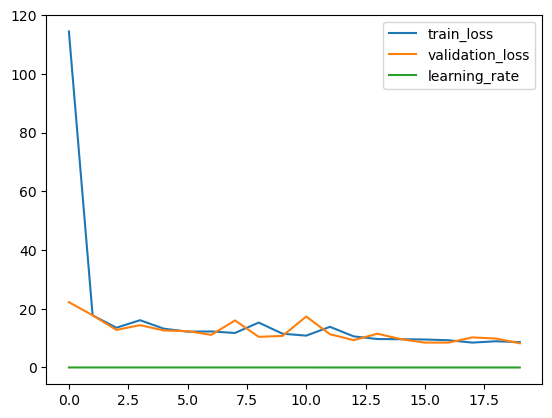

In [5]:
#example cosmosis/qchem QM9 dataset with filter
#use the qchem rdkit branch for rdkit data augmentation

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000, #non-random subset for testing
                              'transforms': {'coulomb': [Pad((29,29)),Reshape((-1))],
                                             'U0': [SqueezeN()]},
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': False}}

model_params = {'in_channels': 29*29, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }
                
metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          squeeze_y_pred=True, batch_size=128, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:25.610625
epoch: 0, lr: 0.01
train loss: 1.6350254085885376, val loss: 1.3883633456732098
learning time: 0:00:50.957534
epoch: 1, lr: 0.01
train loss: 1.3495460307898641, val loss: 1.2823955722545322
learning time: 0:01:16.475741
epoch: 2, lr: 0.01
train loss: 1.2932398199033337, val loss: 1.2264035226483094
learning time: 0:01:41.851981
epoch: 3, lr: 0.01
train loss: 1.2616006461512141, val loss: 1.2311656200572063
learning time: 0:02:06.969238
epoch: 4, lr: 0.01
train loss: 1.2311536933527607, val loss: 1.2592952941593372
learning time: 0:02:32.551487
epoch: 5, lr: 0.01
train loss: 1.1848011609552955, val loss: 1.1484599960477728
learning time: 0:02:57.669996
epoch

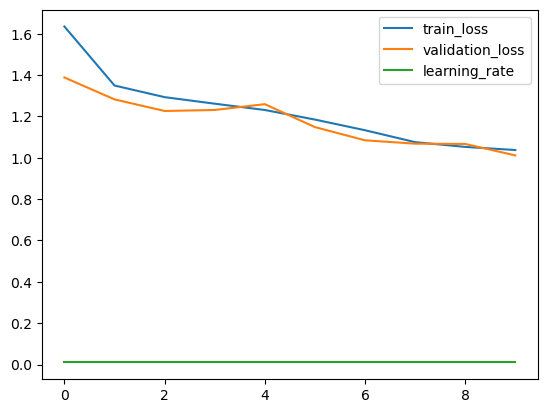

In [6]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        #Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 128, 
                'out_channels': 1,
                'depth': 1,
                'convolution': 'NetConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
                'edge_features': 4,
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                   ])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...
learning time: 0:01:21.010742
epoch: 0, lr: 0.01
train loss: 0.01211959118270999, val loss: 0.022500136769772354
sklearn train metric: 0.6002086964703703, sklearn validation metric: 0.5777080853812255
learning time: 0:02:40.667484
epoch: 1, lr: 0.01
train loss: 0.010545675783463708, val loss: 0.022181200399215704
sklearn train metric: 0.6451162501808677, sklearn validation metric: 0.5803168632295788
learning time: 0:04:00.712523
epoch: 2, lr: 0.01
train loss: 0.010426239166539033, val loss: 0.019713975379572195
sklearn train metric: 0.6505241524089252, skle

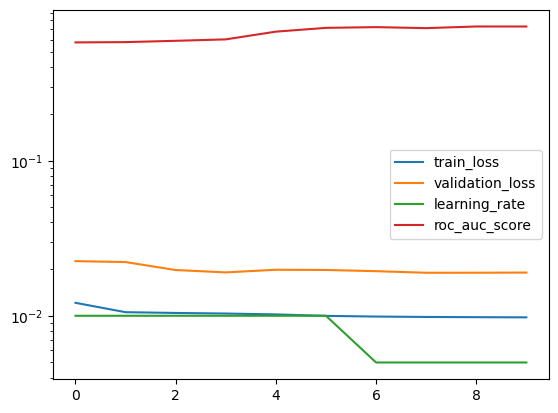

In [7]:
#example graph variational autoencoder without adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': False,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...
FFNet model loaded...
CModel loaded...
learning time: 0:01:35.052510
epoch: 0, lr: 0.01
train loss: 0.018323045227858988, val loss: 0.029465338702197946
sklearn train metric: 0.5035365484694303, sklearn validation metric: 0.4888264874393805
learning time: 0:03:09.887293
epoch: 1, lr: 0.01
train loss: 0.016139863650281947, val loss: 0.02748163061496479
sklearn train metric: 0.6206813992150197, sklearn validation metric: 0.4806081599502163
learning time: 0:04:44.682668
epoch: 2, lr: 0.01
train loss: 0.015798438748123346, val loss: 0.025530819762863366
sklearn

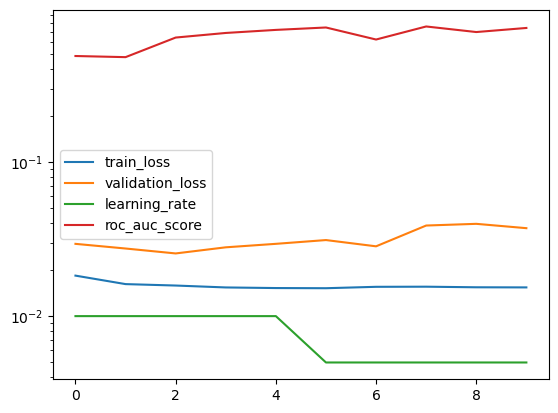

In [8]:
#example graph variational autoencoder with adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': True,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:08.356553
epoch: 0, lr: 0.01
train loss: 1.6653013246066095, val loss: 1.4004448416985964
learning time: 0:00:22.546956
epoch: 2, lr: 0.01
train loss: 1.0903049502052178, val loss: 1.0642141840959851
learning time: 0:00:37.076296
epoch: 4, lr: 0.01
train loss: 0.9476553293503299, val loss: 0.9190608764949598
learning time: 0:00:51.391006
epoch: 6, lr: 0.01
train loss: 0.8671398672069154, val loss: 0.8296658930025602
learning time: 0:01:05.858604
epoch: 8, lr: 0.01
train loss: 0.8068046581511404, val loss: 0.8443457680313211
learning time: 0:01:19.876928
epoch: 10, lr: 0.01
train loss: 0.7702627427437726, val loss: 0.7861976913715664
learning time: 0:01:33.887315
epoc

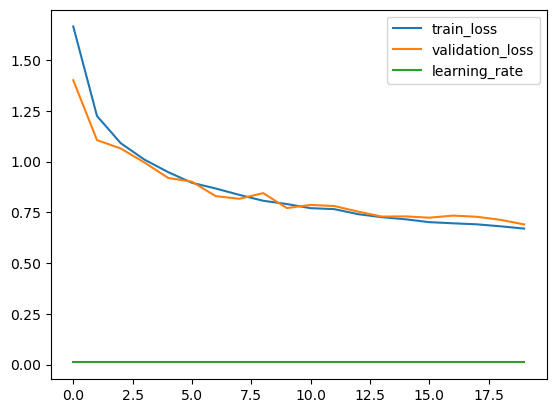

In [2]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                   ])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
pytorch geometric model GraphSAGE loaded...
running model on gpu...
learning time: 0:00:06.895762
epoch: 0, lr: 0.01
train loss: 1.549517416486553, val loss: 1.3413462144763846
learning time: 0:00:20.987298
epoch: 2, lr: 0.01
train loss: 1.1678990309311896, val loss: 1.172258776269461
learning time: 0:00:35.085680
epoch: 4, lr: 0.01
train loss: 1.0485106915319, val loss: 1.0424114002993232
learning time: 0:00:50.109260
epoch: 6, lr: 0.01
train loss: 1.01829567443089, val loss: 0.9762295947263115
learning time: 0:01:04.275325
epoch: 8, lr: 0.01
train loss: 0.9849759417087758, val loss: 0.9917962943252764
learning time: 0:01:18.464977
epoch: 10, lr: 0.01
train loss: 0.9440349323742864, val loss: 0.938095781363939
learning time: 0:01:32.692112
epoch: 12, lr: 0.01
train loss: 0.9279535763403949, val loss: 0.9460892551823666
learning time: 0:01:47.109344
epoch: 14, lr: 0.01
train loss: 0.895

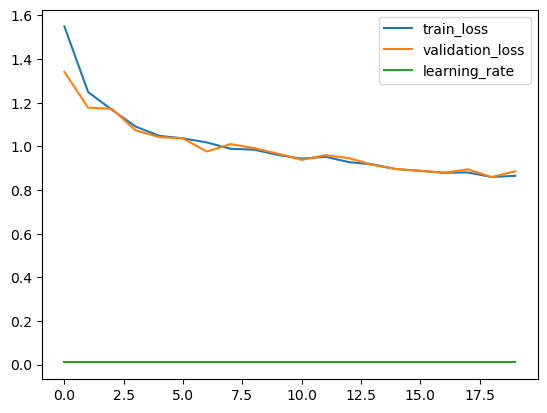

In [3]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'model_name': 'GraphSAGE',
                'softmax': None,
                'pool': 'MeanAggregation',
                'ffnet': True,
                'in_channels': 256, #ffnet params
                'hidden': 256, 
                'out_channels': 1, 
                'pyg_params': {'in_channels': 11, #GraphSAGE params
                               'hidden_channels': 256,
                               'num_layers': 2,
                               'out_channels': 256,
                               'dropout': .1,
                               'norm': 'BatchNorm'}}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0)])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], PygModel, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:06.602731
epoch: 0, lr: 0.01
train loss: 1.4523323927940774, val loss: 1.2787455437999022
learning time: 0:00:20.137162
epoch: 2, lr: 0.01
train loss: 1.1347425075806155, val loss: 1.2125887917844873
learning time: 0:00:33.338819
epoch: 4, lr: 0.01
train loss: 1.0400263822379232, val loss: 1.0476457845223577
learning time: 0:00:47.118842
epoch: 6, lr: 0.01
train loss: 0.9660226477294409, val loss: 1.0040611075727564
learning time: 0:01:01.206734
epoch: 8, lr: 0.01
train loss: 0.9204144427756301, val loss: 0.9762387377651114
learning time: 0:01:14.654657
epoch: 10, lr: 0.01
train loss: 0.8799741840830037, val loss: 0.9795949294378883
learning time: 0:01:27.770121
epoch: 12, lr: 0.01
train loss: 0.8506944246318828, val loss: 0.9435402947036844
learning time: 0:01:40.700186
epoch: 14, lr: 0.005
train loss: 0.8050607957091986, val loss: 0.93320756

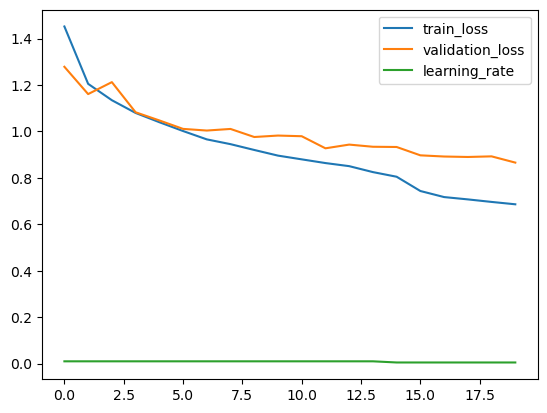

In [4]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom cosmosis model

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {'y': [Index(0)],
                                             'x': [Pad((29,11)), Flatten()]},
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.852023
epoch: 0, lr: 0.01
train loss: 1487.6721384148848, val loss: 1401.9664611816406
learning time: 0:00:08.335194
epoch: 10, lr: 0.01
train loss: 46.99596927040502, val loss: 43.179564476013184
test loss: 38.78383445739746
learning time: 0:00:15.347367


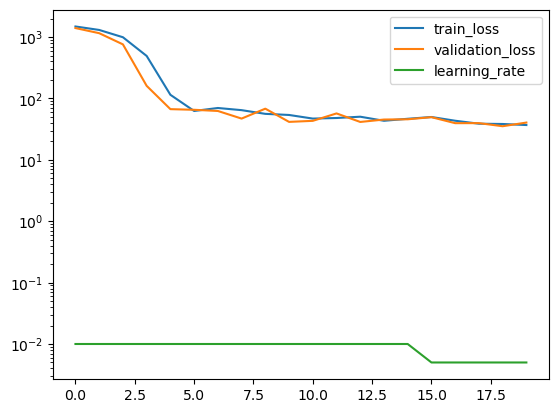

In [5]:
#example using cosmosis/qchem QM7 dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.784253
epoch: 0, lr: 0.01
train loss: 1513.708431846217, val loss: 1431.3775024414062
learning time: 0:00:07.653451
epoch: 10, lr: 0.01
train loss: 64.98444627460681, val loss: 70.27180862426758
test loss: 61.52750015258789
learning time: 0:00:14.014097


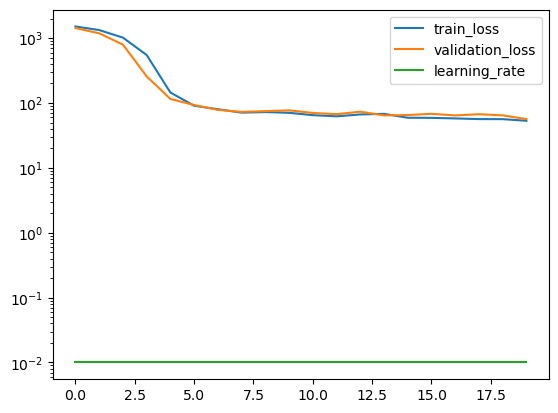

In [6]:
#example using the cosmosis/qchem QM7b dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [7]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {},
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
longest molecule length:  20  index:  233
(20,)


{'model_input': {'X': array([6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.], dtype=float32)},
 'criterion_input': {'target': array([89.35384], dtype=float32)}}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.227238
epoch: 0, lr: 0.01
train loss: 43.96184024810791, val loss: 11.357409000396729
test loss: 3.531156539916992
learning time: 0:00:07.968128


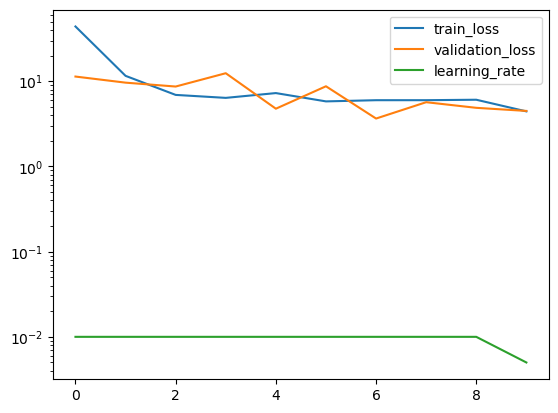

In [3]:
#example using the cosmosis/qchem QM7X dataset with filter and custom cosmosis model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {'coulomb': [Pad((23,23)), Flatten()]},
                              'selector': ['opt'],
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.240802
epoch: 0, lr: 0.01
train loss: 457.9350747501149, val loss: 272.0658438546317
learning time: 0:00:12.232179
epoch: 10, lr: 0.01
train loss: 33.10776222453398, val loss: 31.107430866786412
test loss: 28.233738490513392
learning time: 0:00:22.368330


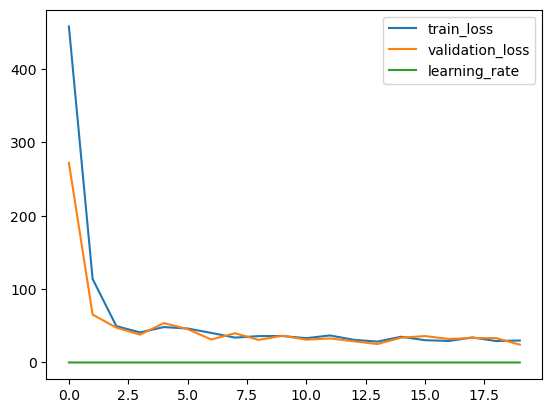

In [4]:
#example using cosmosis/qchem ANI1x dataset with filter and custom cosmosis model

model_params = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'transforms': {'coulomb': [Pad((63,63)), Flatten()]},
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}

opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=20)